## MCX simulation Stage 3.2 with multi-distance detector

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bjdata: filename=bjdata-0.4.1-cp311-cp311-linux_x86_64.whl size=22196 sha256=1fe76ede49e2036e7f211149b5fcbed5de971148e70c33b4b50a1258b713e91b
  Stored in directory: /root/.cache/pip/wheels/e4/d5/4a/8d5ccb70c0eb1f07a10da8548e50b7fc0cbdfd014f5eaa45c3
Successfully built bjdata


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path to your folder containing the .py script
folder_path = '/content/drive/MyDrive/MCX_data'

# Add to sys.path so you can import the script
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms
from FD_msNIRS import extract_freq as ef

In [6]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [7]:
mu_a_path = '/content/drive/MyDrive/MCX_data/30_mu_as_df.csv'
mu_sp_path = '/content/drive/MyDrive/MCX_data/30_mu_s_primes_df.csv'

In [8]:
# Load absorption data
mu_a_df = pd.read_csv(mu_a_path, header=None)
wls = mu_a_df.iloc[0].values.astype(float)
ua = mu_a_df.iloc[1:].values.astype(float)

# Load reduced scattering data
mu_sp_df = pd.read_csv(mu_sp_path, header=None)
us_prime = mu_sp_df.iloc[1:].values.astype(float)

# Print shapes for verification
print("Wavelengths:", wls)
print("mu_a shape:", ua.shape)
print("mu_sp shape:", us_prime.shape)

Wavelengths: [784. 800. 818. 835. 851. 868. 881. 894.]
mu_a shape: (30, 8)
mu_sp shape: (30, 8)


In [9]:
g=0.85
us = us_prime/(1-g)
distance = [2, 2.5, 3.0 ,3.5] # cm

In [11]:
# compute ua, distance, and us in mm-1
ua_mm = ua/10
us_mm = us/10
distance_mm = [d*10 for d in distance]

In [12]:
distance_mm

[20, 25.0, 30.0, 35.0]

### Run simulations

In [ ]:
dictt_ms={} # row, column, distances
for j in range(ua_mm.shape[0]): # (30, 8) -> 30
    for i in range(0, ua_mm.shape[1]): # (30, 8) -> 8
        TPSF_list, time_unit = ms(ua_mm[j, i], us_mm[j, i], g=0.85, n=1.370, distance=distance_mm, tend=1e-08, devf=1000, nphoton=1.2e8)
        for k, d in enumerate(distance_mm):
            label = f"{j}, {wls[i]}, {d}" # row, wavelength, distance
            dictt_ms[label] = [TPSF_list[k], time_unit]

nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1


In [3]:
print(len(dictt_ms))

NameError: name 'dictt_ms' is not defined

In [ ]:
# save the dictionary!
with open('dictt_ms_stage_4.pkl', 'wb') as f:
    pickle.dump(dictt_ms, f)
print("Dictionary dictt_ms saved to dictt_ms_stage_4.pkl")

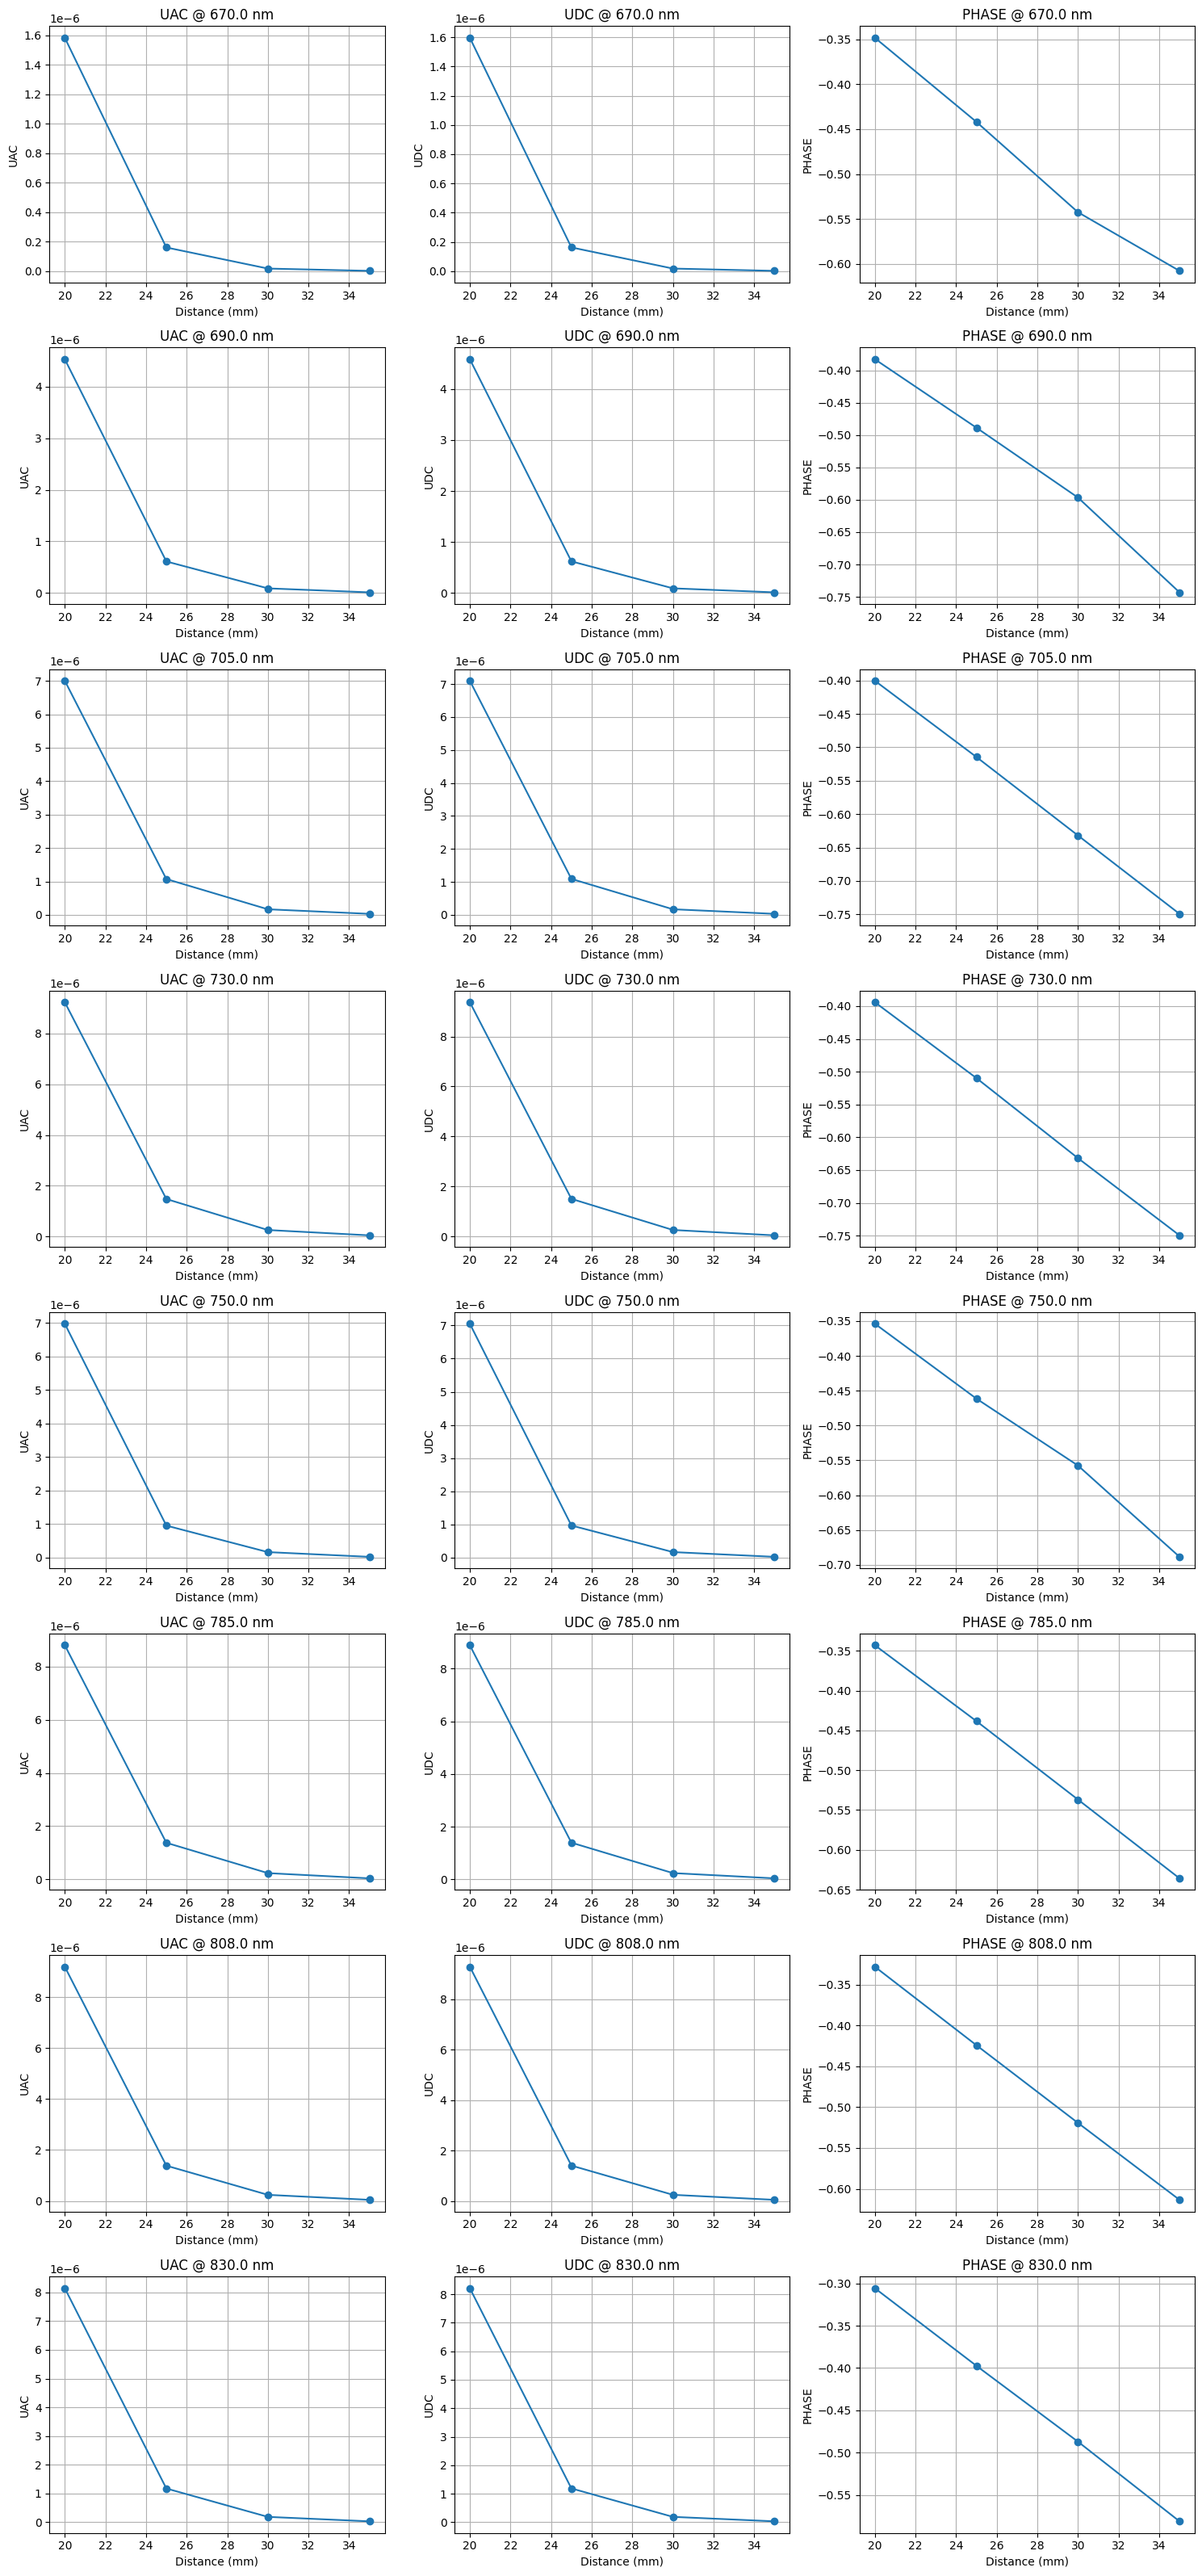

In [ ]:
# --- Frequency domain analysis ---
# create (30, 8, 4) matrix that contains information.
target_freq = 110e6
uac = np.zeros((ua_mm.shape[0], ua_mm.shape[1], len(distance_mm)))
udc = np.zeros((ua_mm.shape[0], ua_mm.shape[1], len(distance_mm)))
phase1 = np.zeros((ua_mm.shape[0], ua_mm.shape[1], len(distance_mm)))
phase2 = np.zeros((ua_mm.shape[0], ua_mm.shape[1], len(distance_mm)))

for label, (TPSF, tstep) in dictt_ms.items():
    row, wl, distance = label.split(',')
    uac_i, udc_i, p1, p2 = ef(target_freq, [TPSF], tend=1e-08, devf=1000)
    uac[int(row), int(wl), int(distance)] = uac_i
    udc[int(row), int(wl), int(distance)] = udc_i
    phase1[int(row), int(wl), int(distance)] = p1
    phase2[int(row), int(wl), int(distance)] = p2

In [ ]:

columns = []
all_rows = []

# uac_distance_wavelength(f)
# udc_distance_wavelength(f)
for r in range(uac.shape[0]):  # 30 rows
    row = []
    for d in range(uac.shape[2]):     # 4 distances
        for w in range(uac.shape[1]): # 8 wavelengths
            if r == 0:
                columns.extend([
                    f"U_AC_{d+1}_{w+1}",
                    f"U_DC_{d+1}_{w+1}",
                    f"Phase_{d+1}_{w+1}"
                ])
            row.extend([
                uac[r, w, d],
                udc[r, w, d],
                phase1[r, w, d]
            ])
    all_rows.append(row)

# Save to CSV
df = pd.DataFrame(all_rows, columns=columns)
df.to_csv("stage_4.csv", index=False)
print("Saved stage_4.csv with shape", df.shape)

### Data visualization

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting settings
sns.set(style="whitegrid")
metrics = {'U_AC': uac, 'U_DC': udc, 'Phase': phase1}
distance_labels = ['D1', 'D2', 'D3', 'D4']

for metric_name, metric_data in metrics.items():
    plt.figure(figsize=(16, 4))

    for d in range(4):  # For each distance index
        plt.subplot(1, 4, d + 1)

        # Extract (30, 8) data for current distance
        data_slice = metric_data[:, :, d]  # shape (30, 8)

        # Reshape into long-form DataFrame for seaborn
        data_melted = data_slice.reshape(-1, 1)
        df = sns.load_dataset('tips')  # dummy init
        df = {
            'Wavelength': np.tile(np.arange(1, 9), 30),
            'Value': data_slice.flatten()
        }
        sns.violinplot(x='Wavelength', y='Value', data=pd.DataFrame(df), inner='box')

        plt.title(f'{metric_name} at {distance_labels[d]}')
        plt.xlabel('Wavelength Index')
        plt.ylabel(metric_name)

    plt.tight_layout()
    plt.suptitle(f'Violin Plots of {metric_name} across Distances', y=1.05, fontsize=14)
    plt.show()
